# Étude de marché: entreprise IAA souhaitant s'exporter à l'international

Etude data - Projet 9 - Melvin Derouck (Janvier 2024) / OpenClassrooms - ENSAE-ENSAI

<p><em>Data source</em> <a href="http://www.fao.org/faostat/fr/#data">FAO, <a href="https://www.kaggle.com/datasets">Kaggle</a><br>
<em>Industrie Agroalimentaire (en abrégé IAA)</em></p>

# Import des librairies

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import math

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as sch

import warnings
warnings.filterwarnings("ignore")
from adjustText import adjust_text

In [4]:
#Versions utilisées

print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Seaborn : " + str(sns.__version__))

Pandas : 1.4.1
Numpy : 1.25.0
Seaborn : 0.11.2


# Import des fichiers

In [5]:
df = pd.read_csv(
    r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\RW\CSV\merges\main_df.csv",
    sep=","
    )

# ACP

In [6]:
#dimension
print(df.shape) 

#nombre d'observations
n = df.shape[0]

#nombre de variables
p = df.shape[1]

df.head(5)

(162, 9)


,iso3,Pays,Continent,Population,PIB (US$)/hab,Disponibilité alimentaire en quantité (kg/personne/an),Exportations - Quantité(Tonnes),Importations - Quantité(Tonnes),distance
0,AFG,Afghanistan,Asie,36296113.0,519.884773,1.53,0.0,29000.0,5590.3810
1,ZAF,Afrique du Sud,Afrique,57009756.0,6131.479450,35.69,63000.0,514000.0,9353.5520
2,ALB,Albanie,Europe,2884169.0,4531.020806,16.36,0.0,38000.0,1603.5340
3,DZA,Algérie,Afrique,41389189.0,4111.294110,6.38,0.0,2000.0,1340.3900
4,DEU,Allemagne,Europe,82658409.0,44552.819372,19.47,646000.0,842000.0,439.8984


Standardisation des données

In [7]:
#Création d'un nouveau df qui contiendra les données numériques standardisées

df_numeric_datas = df[["Population", "PIB (US$)/hab", "Disponibilité alimentaire en quantité (kg/personne/an)", "Exportations - Quantité(Tonnes)", "Importations - Quantité(Tonnes)", "distance"]]

sc = StandardScaler()
df_std = sc.fit_transform(df_numeric_datas.astype(float))

df_std

array([[-5.16682974e-02, -6.91778213e-01, -1.16934405e+00,
        -2.27161690e-01, -3.17431969e-01, -9.60529235e-02],
       [ 8.02232817e-02, -4.01308484e-01,  9.76936201e-01,
        -9.28388505e-02,  2.27272587e+00,  9.07704698e-01],
       [-2.64414749e-01, -4.84152099e-01, -2.37571914e-01,
        -2.27161690e-01, -2.69367184e-01, -1.15947206e+00],
       [-1.92387611e-02, -5.05878169e-01, -8.64617490e-01,
        -2.27161690e-01, -4.61626323e-01, -1.22966095e+00],
       [ 2.43537931e-01,  1.58747311e+00, -4.21699359e-02,
         1.15018044e+00,  4.02442024e+00, -1.46985076e+00],
       [-9.29247440e-02, -5.06679512e-01, -6.01987179e-01,
        -2.27161690e-01,  1.00701987e+00,  1.49324656e-01],
       [-2.82171728e-01,  7.75941139e-02,  2.13364052e+00,
        -2.27161690e-01, -4.34923665e-01,  2.02257061e-01],
       [-7.20116474e-02,  3.58163558e-01,  1.45884397e+00,
        -2.05840604e-01,  3.38355644e+00, -3.35012934e-01],
       [-3.01499593e-03,  3.77177231e-02,  1.388

In [8]:
#verif des moyennes
print(np.mean(df_std,axis=0))

[-2.19303314e-17 -2.19303314e-17  2.19303314e-17 -2.19303314e-17
 -2.19303314e-17 -2.46716228e-17]


In [9]:
#verif de écart types => ils sont unitaires 
print(np.std(df_std,axis=0,ddof=0))

[1. 1. 1. 1. 1. 1.]


Instanciation du modèle et définition des variables

In [10]:
#instance 
n_comp = 6

pca = PCA(n_components=n_comp)
pca.fit(df_std)
print('Nb de composantes calculées : ', pca.n_components_)

Nb de composantes calculées :  6


In [11]:
#on affiche la variance expliqué

print(pca.explained_variance_)

[1.74794661 1.21353616 1.11828199 0.85132675 0.62983046 0.4763451 ]


In [12]:
#et la valeur corrigée

eigval = (n-1)/n*pca.explained_variance_
print(eigval)

[1.73715682 1.2060452  1.11137902 0.84607165 0.62594262 0.4734047 ]


In [13]:
#puis sous forme de %

print(pca.explained_variance_ratio_)

[0.28952614 0.20100753 0.18522984 0.14101194 0.10432377 0.07890078]


Choix du nb de variables

In [14]:
# % de variance expliqué pour chaque variable

eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(6)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,1.747947,29.0,29.0
1,Dim2,1.213536,20.0,49.0
2,Dim3,1.118282,19.0,68.0
3,Dim4,0.851327,14.0,82.0
4,Dim5,0.629830,10.0,92.0
5,Dim6,0.476345,8.0,100.0


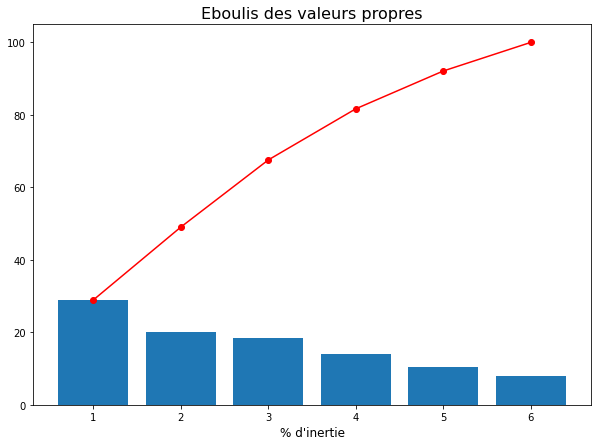

In [15]:
#scree plot avec méthode du coude pour déterminer le nombre de variable optimal

def display_scree_plot(pca):
    scree=pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.xlabel("% d'inertie", fontsize=12)
    plt.title('Eboulis des valeurs propres', fontsize=16)
    # plt.savefig(r"C:\Users\derou\OneDrive\Bureau\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\éboulis des valeurs propres.png")
    plt.show(block=False)

plt.figure(figsize=(10,7))

display_scree_plot(pca)

Le Scree plot représente la part de variance expliqué cumulée par nb de composantes
En se basant sur ce graphique, on choisis d’appliquer le modèle sur 2 composantes principales
La CP1 représentera 29% de la variance et la CP2 20%. Donc à elles deux 49%.

Application du modèle sur le nb de variables choisi

In [16]:
#on applique le modèle sur 2 composantes principales car l'objectif est de visualiser

pca = PCA(n_components=2).fit(df_std)
xk_projected = pca.transform(df_std)

In [17]:
# Transformation en DataFrame pandas

df_pca = pd.DataFrame({
    "Dim1" : xk_projected[:,0], 
    "Dim2" : xk_projected[:,1],
    "Pays" : df["Pays"],
    "Continent" : df["Continent"]
})

df_pca.head()

,Dim1,Dim2,Pays,Continent
0,-1.212439,0.089470,Afghanistan,Asie
1,1.114910,0.874632,Afrique du Sud,Afrique
2,-0.476510,-0.701566,Albanie,Europe
3,-0.853260,-0.550663,Algérie,Afrique
4,3.420883,-0.143111,Allemagne,Europe


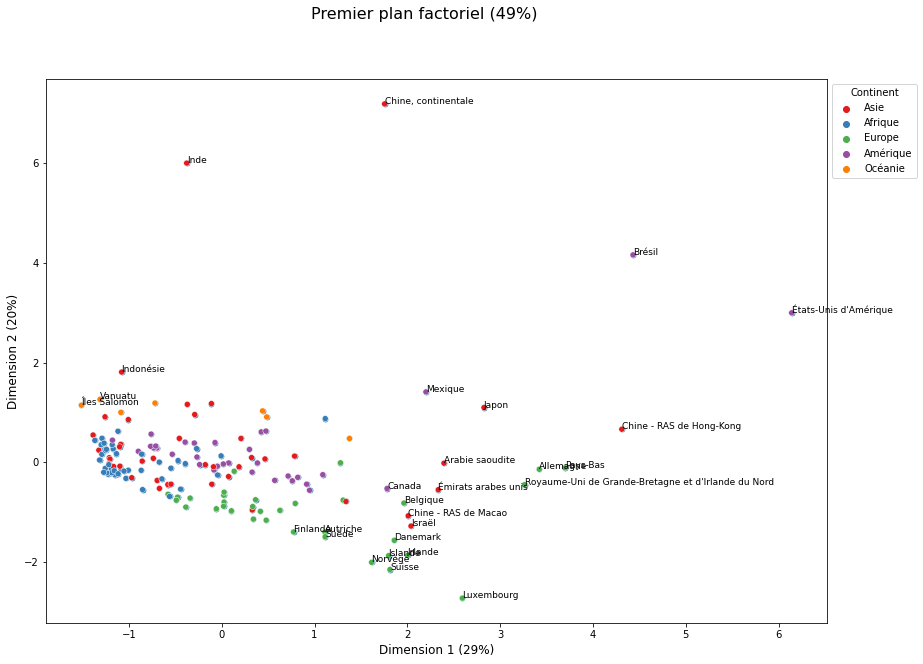

In [18]:
#visualisation du plan factoriel avec labels des pays sur les valeurs en périphérie

fig, ax = plt.subplots(figsize=(14, 10))
df_pca.plot.scatter("Dim1", "Dim2", ax = ax) 

scatter = df_pca.plot.scatter("Dim1", "Dim2", ax=ax)

# boucle sur chaque pays avec valeurs limites pour limiter le nb de labels
for k in df_pca.iterrows():
   
    if (abs(k[1]['Dim1']) > 1.5) | (abs(k[1]['Dim2']) > 1.25):
        ax.annotate(k[1]["Pays"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)

plt.xlabel("Dimension 1 (29%)", fontsize=12) 
plt.ylabel("Dimension 2 (20%)", fontsize=12)
plt.suptitle("Premier plan factoriel (49%)", fontsize=16)

#associer une couleur par continent
sns.scatterplot(data=df_pca, x="Dim1", y="Dim2", hue="Continent", palette="Set1", ax=scatter)
plt.legend(title="Continent", bbox_to_anchor=(1, 1), loc='upper left')

# plt.savefig(
    # r"C:\Users\derou\OneDrive\Bureau\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\premier plan factoriel avec continents.png",
# )

plt.show()

Cette représentation nous permet de voir les pays qui se ressemble en terme de caractéristiques (écono, démo…)

La labelisation des continents par couleurs permet d’observer un effet continent : Les pays d'Europe sont + regroupés en bas a droite du nuage, ceux de l'Océanie sur le haut du nuage, Afrique sur la gauche...

4 points qui se distinguent clairement des autres, qui ne sont pas nécessairement des outliers mais des pays qui bénéficient d’une valeur élevée sur une des variables (population, PIB…). 
J’ai décidé d'écarter ces valeurs du dataset, afin de ne pas biaiser les résultats des clustering et notamment kmeans qui est sensible aux outliers

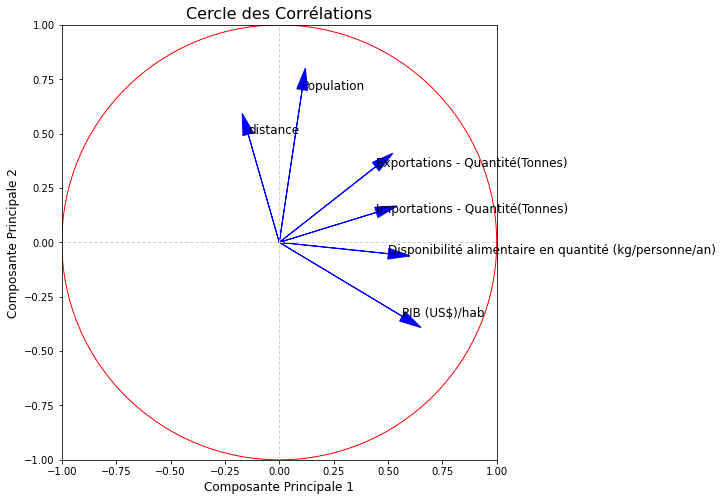

In [19]:
# Création d'un cercle des corrélations

variable_loadings = pca.components_[:2, :]

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

for i, (comp1, comp2) in enumerate(zip(variable_loadings[0, :], variable_loadings[1, :])):
    ax.arrow(0, 0, comp1, comp2, head_width=0.05, head_length=0.1, fc='blue', ec='blue')
    ax.text(comp1, comp2, df_numeric_datas.columns[i], fontsize=12)

circle = plt.Circle((0, 0), 1, fill=False, color='red')
ax.add_artist(circle)

ax.axhline(0, color='lightgray', linestyle='--', linewidth=1)
ax.axvline(0, color='lightgray', linestyle='--', linewidth=1)

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("Composante Principale 1", fontsize=12)
ax.set_ylabel("Composante Principale 2", fontsize=12)
ax.set_title("Cercle des Corrélations", fontsize=16)

# plt.savefig(
#     r"C:\Users\derou\OneDrive\Bureau\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\cercle corr.png",
# )

plt.show()

La variable 'Population' a une forte corrélation positive avec la composante principale 2, tandis que les variables liées aux exportations et aux importations sont fortement corrélées négativement avec la CP1 et peu avec la CP2.

La CP1 semble capturer des informations liées aux variables économiques et commerciales comme les importations, exportations, et le PIB par habitant.

La CP2 semble être plus associée à la variable "Population" et "Distance".


In [20]:
#verif des corrélations des variables en calculant le coeff de correlation (Dispo + importations)

corr = df["distance"].corr(df["PIB (US$)/hab"], method='spearman')

corr

-0.21599975160924748

In [21]:
# coeff spearman

In [22]:
corr = df["Disponibilité alimentaire en quantité (kg/personne/an)"].corr(df["PIB (US$)/hab"], method='spearman')

corr

0.703075747345306

In [23]:
# on va exclure du df sur lequel on va appliquer les modèles de clustering les 4 pays avec des valeurs atypiques pour ne pas biaiser l'étude

outliers = "Inde", "Brésil", "Chine, continentale", "États-Unis d'Amérique"

df_pca_filt = df_pca[~df_pca['Pays'].isin(outliers)]
df_pca_filt.reset_index(drop=True, inplace=True)

df_no_outliers = df[~df['Pays'].isin(outliers)]
df_no_outliers.reset_index(drop=True, inplace=True)

# Clustering avec k-means

In [24]:
data_pca = df_pca_filt[['Dim1', 'Dim2']]

In [25]:
#instance du modèle

cluster_range = [2,3,4,5,6,7,8]

inertie = []

for c in cluster_range:
    kmeans=KMeans(init='k-means++', n_clusters=c).fit(data_pca)
    inertie.append(kmeans.inertia_)

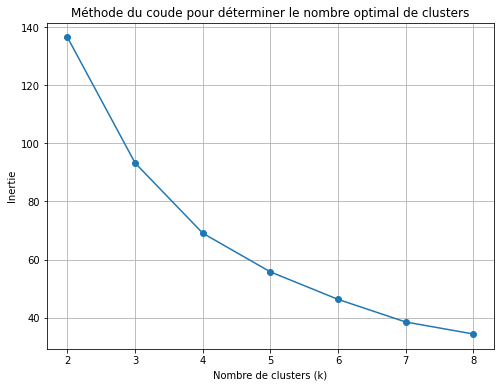

In [26]:
#représentation avec méthode du coude et choix du nb de clusters

plt.figure(figsize=(8,6))
plt.plot(cluster_range, inertie, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.grid(True)

# plt.savefig(
#     r"C:\Users\derou\OneDrive\Bureau\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\coude.png",
# )

plt.show()

La méthode du coude montre la somme des distances au carré des points de données jusqu'au centroïde le plus proche pour différents nombres de clusters 

Ici coude, point de cassure = 4 clusters

In [27]:
# il y aura 4 clusters. Affichage de la table avec la nouvelle colonne labels

kmeans = KMeans(n_clusters=4, random_state=1).fit(data_pca)
labels = kmeans.labels_

dfa_pca_kmeans = pd.DataFrame(data=data_pca)
dfa_pca_kmeans['labels_kmeans']=labels

dfa_pca_kmeans

,Dim1,Dim2,labels_kmeans
0,-1.212439,0.089470,3
1,1.114910,0.874632,0
2,-0.476510,-0.701566,0
3,-0.853260,-0.550663,3
4,3.420883,-0.143111,2
...,...,...,...
153,-0.470888,0.032514,3
154,2.332605,-0.552802,2
155,-0.711534,0.323427,3
156,-1.268713,0.381668,3


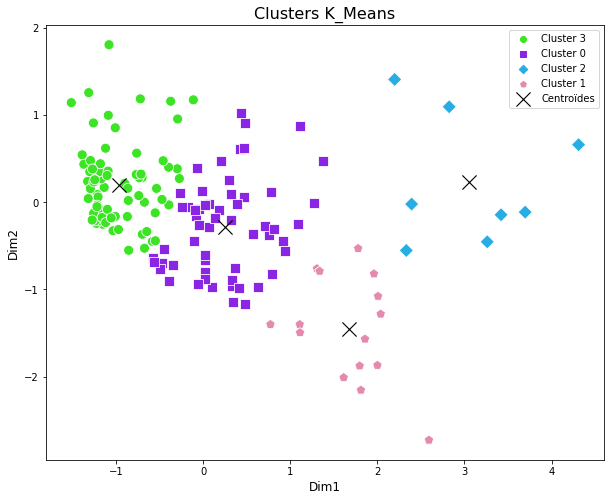

In [28]:
#représentation des clusters et des centroides sur nuage de points

cluster_data = dfa_pca_kmeans.copy()
cluster_data['Cluster'] = cluster_data['labels_kmeans'].apply(lambda x: f'Cluster {x}')
 
cluster_colors = ['#3CE425', '#8A25E4', '#25ADE4', '#E38AAE']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=cluster_data, x='Dim1', y='Dim2', hue='Cluster', palette=cluster_colors, s=100, style='Cluster', markers=['o', 's', 'D', 'p'])
sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], color='black', marker='x', s=200, label='Centroïdes')

plt.title('Clusters K_Means', fontsize=16)
plt.xlabel('Dim1', fontsize=12)
plt.ylabel('Dim2', fontsize=12)
plt.legend(title='')

plt.savefig(
     r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\clusters_kmeans.png",
 )

plt.show()

Ce graphique représente les données projetées dans un espace bidimensionnel, avec chaque point coloré selon son appartenance à l'un des 4 clusters. 
Les centroïdes de chaque cluster sont également marqués.

A première vue les pays appartenant au cluster vert et violet sont plutôt équilibrés en terme de nombres d’individus, tandis que les individus dans le cluster bleu et le rose sont moins nombreux et plus dispersés

In [29]:
#on créé une nouvelle colonne dans le df principal pour avoir l'information des clusters

df_no_outliers['Cluster_kmeans'] = dfa_pca_kmeans['labels_kmeans']
df_pca_filt['Cluster_kmeans'] = dfa_pca_kmeans['labels_kmeans']

In [30]:
#analyse des moyennes des variables des 4 clusters identifiés

cluster_summary = df_no_outliers.groupby('Cluster_kmeans').mean()
cluster_summary

,Population,PIB (US$)/hab,Disponibilité alimentaire en quantité (kg/personne/an),Exportations - Quantité(Tonnes),Importations - Quantité(Tonnes),distance
Cluster_kmeans,,,,,,
0,1.716354e+07,13787.389320,31.164035,58263.157895,65842.105263,5419.013089
1,1.047480e+07,58613.256429,28.105333,92533.333333,92866.666667,2348.094247
2,5.857275e+07,36109.778306,32.887500,401125.000000,791500.000000,4965.839475
3,2.946003e+07,2749.503526,8.763846,10858.974359,29115.384615,7052.329603


In [31]:
#0 = Population relativement basse, PIB plutot bas, moyennes des variables alimentaires moyennes, éloignés de la France
#1 = Population basse, PIB élevé, moyennes des variables alimentaires moyennes, proches de la France
#2 = Population élevée, PIB moyen, moyennes des variables alimentaires trés élevées, plutot éloignés de la France
#3 = Population moyenne, PIB trés bas, moyennes des variables alimentaires trés basses, éloignés de la France

renom_cluster_k = {0:"Peu pertinent",
                   1:"Pertinent",
                   2:"Trés pertinent",
                   3:"Trés peu pertinent"
                   }

df_no_outliers['Cluster_kmeans'] = df_no_outliers['Cluster_kmeans'].map(renom_cluster_k)
df_pca_filt['Cluster_kmeans'] = df_pca_filt['Cluster_kmeans'].map(renom_cluster_k)

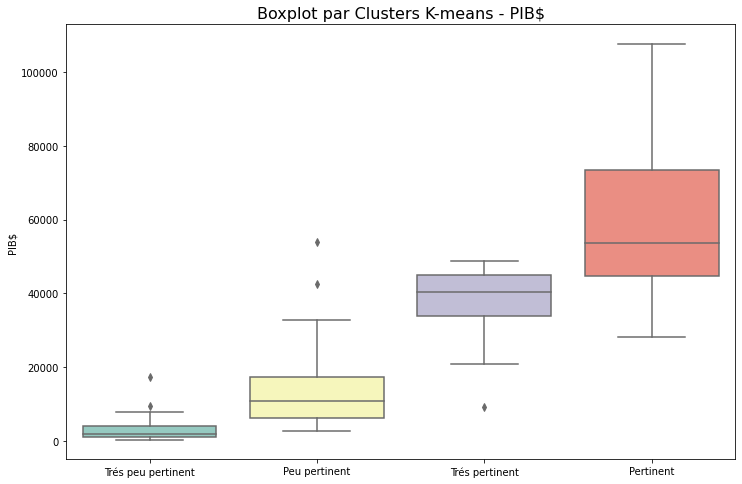

In [32]:
# Caractérisation des clusters avec des boxplots pour la variable "PIB"

plt.figure(figsize=(12, 8))

sns.boxplot(x='Cluster_kmeans', y='PIB (US$)/hab', data=df_no_outliers, palette='Set3')
plt.xlabel('')
plt.ylabel('PIB$')
plt.title('Boxplot par Clusters K-means - PIB$', fontsize=16)

plt.savefig(
     r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\boxplot PIB$ k-means.png",
)

plt.show()

Trés peu pertinent et Peu pertinent = contient des pays avec des valeurs de PIB basses 

Pertinent = Pays ayants les valeurs de PIB les plus élevés, avec une grande variance au sein des données

Très pertinent = Pays avec des valeurs de PIB relativement haute, mais faible variance au sein du cluster et un outlier qui se démarque clairement des autres 

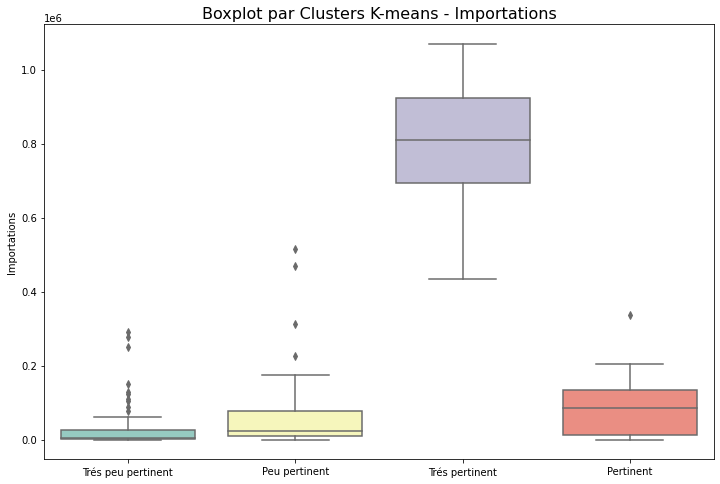

In [33]:
# Caractérisation des clusters avec des boxplots pour la variable "importations"

plt.figure(figsize=(12, 8))

sns.boxplot(x='Cluster_kmeans', y='Importations - Quantité(Tonnes)', data=df_no_outliers, palette='Set3')
plt.xlabel('')
plt.ylabel('Importations')
plt.title('Boxplot par Clusters K-means - Importations', fontsize=16)

plt.savefig(
     r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\boxplot distance k-means.png",
)

plt.show()

Le boxplot de "Trés peu pertinent', 'Peu pertinent' et 'Pertinent' montre des médianes qui sont faibles et peu de variance, avec de nombreux outliers au sein des clusters

Le boxplot trés pertinent montre que les valeurs sont clairements plus élevés pour les pays de ce cluster

In [34]:
# affichage des pays dans le cluster "Trés pertinent"

pays_kmeans = df_no_outliers[df_no_outliers['Cluster_kmeans']=="Trés pertinent"]

In [35]:
pays_kmeans

,iso3,Pays,Continent,Population,PIB (US$)/hab,Disponibilité alimentaire en quantité (kg/personne/an),Exportations - Quantité(Tonnes),Importations - Quantité(Tonnes),distance,Cluster_kmeans
4,DEU,Allemagne,Europe,82658409.0,44552.819372,19.47,646000.0,842000.0,439.8984,Trés pertinent
7,SAU,Arabie saoudite,Asie,33101179.0,20803.745918,43.36,10000.0,722000.0,4694.5000,Trés pertinent
30,HKG,Chine - RAS de Hong-Kong,Asie,7306322.0,46165.856512,53.51,663000.0,907000.0,9639.4760,Trés pertinent
70,JPN,Japon,Asie,127502725.0,38386.511146,18.50,10000.0,1069000.0,9725.6290,Trés pertinent
93,MEX,Mexique,Amérique,124777324.0,9287.849736,32.52,9000.0,972000.0,9206.8130,Trés pertinent
110,NLD,Pays-Bas,Europe,17021347.0,48675.222335,20.33,1418000.0,608000.0,427.9169,Trés pertinent
115,GBR,Royaume-Uni de Grande-Bretagne et d'Irlande du...,Europe,66727461.0,40361.417383,31.94,359000.0,779000.0,342.9475,Trés pertinent
154,ARE,Émirats arabes unis,Asie,9487203.0,40644.804043,43.47,94000.0,433000.0,5249.5350,Trés pertinent


In [36]:
# silouhette score pour mesure qualité clusters kmeans
clusters = kmeans.fit_predict(data_pca)

In [37]:
# Le coefficient de silhouette est une mesure d'évaluation de la qualité du clustering réalisé par une méthode comme K-means. 
# Il prend des valeurs allant de -1 à 1.
# Un coefficient de 0.68 indique un clustering raisonnablement bon. Cela suggère que les clusters sont relativement bien définis et séparés, mais il y a encore une marge d'amélioration.

silhouette_avg = silhouette_score(data_pca, clusters)
print("Coefficient de Silhouette :", silhouette_avg)

Coefficient de Silhouette : 0.6822320176581262


# Classification ascendante hiérarchique (CAH)

In [38]:
data_cah = df_pca_filt[['Dim1', 'Dim2']]

scdf = StandardScaler()
std_cah = scdf.fit_transform(data_cah.astype(float))

std_cah

array([[-9.63501156e-01,  3.09273977e-01],
       [ 1.00902518e+00,  1.42171504e+00],
       [-3.39770680e-01, -8.11490573e-01],
       [-6.59081813e-01, -5.97686525e-01],
       [ 2.96343386e+00, -2.02543419e-02],
       [-1.65716057e-01,  5.68680533e-01],
       [ 7.08510030e-01, -3.47662620e-01],
       [ 2.09323360e+00,  1.53653390e-01],
       [ 4.24554313e-01,  1.04345632e+00],
       [-4.28282530e-01, -4.53337733e-01],
       [ 1.23043630e+00,  8.56122714e-01],
       [ 1.00493614e+00, -1.80314083e+00],
       [-5.25921466e-01, -3.37986574e-01],
       [ 8.65671194e-01, -6.16172817e-01],
       [-1.00201264e+00,  1.47261436e+00],
       [ 5.47313475e-01, -3.35252723e-01],
       [ 1.72704705e+00, -9.79804148e-01],
       [-3.88148227e-01,  4.08176505e-01],
       [-1.86422033e-01,  7.27718588e-01],
       [-3.51028468e-01, -8.99655782e-01],
       [-8.97315046e-01,  4.24569830e-01],
       [ 8.18072677e-02, -7.56238769e-01],
       [-9.58009100e-01, -1.21583148e-01],
       [ 8.

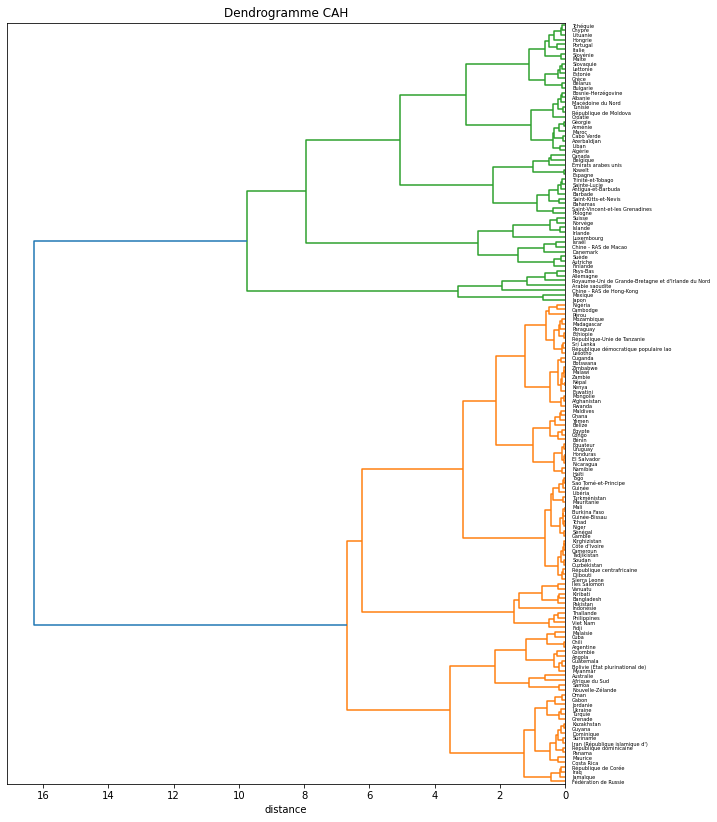

In [39]:
#générer le dendrogramme pour déterminer clusters
linkage_matrix = linkage(std_cah, method='ward', metric='euclidean')

# Affichage du dendrogramme
plt.figure(figsize=(10,14))
dendrogram(linkage_matrix, orientation='left', labels=df_pca_filt['Pays'].values)
plt.xlabel("distance")

plt.title("Dendrogramme CAH")
plt.show()
 
# Attribution des étiquettes de cluster
clusters = fcluster(linkage_matrix, t=1.5, criterion='distance')

In [40]:
std_dfcah = pd.DataFrame(data=std_cah, columns=['Dim1', 'Dim2'])

std_dfcah

,Dim1,Dim2
0,-0.963501,0.309274
1,1.009025,1.421715
2,-0.339771,-0.811491
3,-0.659082,-0.597687
4,2.963434,-0.020254
...,...,...
153,-0.335005,0.228576
154,2.041073,-0.600717
155,-0.538963,0.640751
156,-1.011196,0.723268


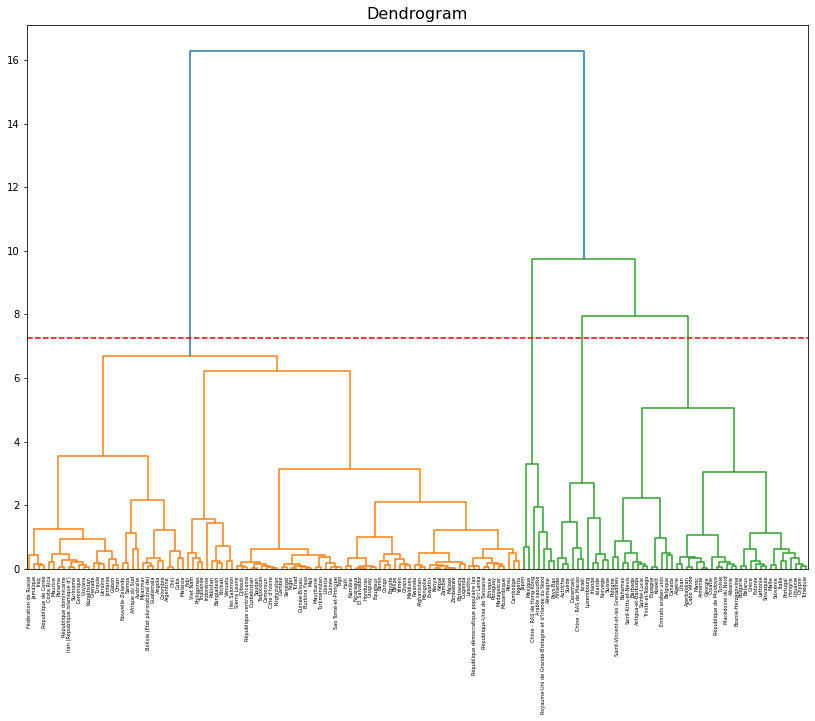

In [41]:
#tracer droite pour clusters
X = std_dfcah.values

plt.figure(figsize=(14,10))
dendogram = sch.dendrogram(sch.linkage(X, method='ward'), labels=df_pca_filt['Pays'].values)
plt.axhline(y=7.25, color='r', linestyle='--')

plt.title('Dendrogram', fontsize=16)

plt.savefig(
   r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\dendrogram.png",
)

plt.show()

Le Dendrogramme représente la manière dont les clusters sont formés en hiérarchie. 

Chaque fusion de clusters est représentée par une ligne et une couleur, et la hauteur de la ligne indique la distance ou la dissimilarité entre les clusters fusionnés.

On remarque les tailles différentes des différents clusters effectués.

On choisis ici de selectionner 4 clusters.

In [42]:
#instance du modèle
agg_clustering = AgglomerativeClustering(n_clusters=4)

agg_clustering.fit(std_dfcah)

AgglomerativeClustering(n_clusters=4)

In [43]:
std_dfcah['Cluster_CAH'] = agg_clustering.labels_

In [44]:
std_dfcah

,Dim1,Dim2,Cluster_CAH
0,-0.963501,0.309274,0
1,1.009025,1.421715,0
2,-0.339771,-0.811491,1
3,-0.659082,-0.597687,1
4,2.963434,-0.020254,2
...,...,...,...
153,-0.335005,0.228576,0
154,2.041073,-0.600717,1
155,-0.538963,0.640751,0
156,-1.011196,0.723268,0


In [45]:
df_no_outliers = pd.concat([df_no_outliers, std_dfcah.Cluster_CAH], axis=1)
df_pca_filt = pd.concat([df_pca_filt, std_dfcah.Cluster_CAH], axis=1)

In [46]:
#comprendre la caractérisation des clusters 

df_no_outliers.groupby("Cluster_CAH").mean()

,Population,PIB (US$)/hab,Disponibilité alimentaire en quantité (kg/personne/an),Exportations - Quantité(Tonnes),Importations - Quantité(Tonnes),distance
Cluster_CAH,,,,,,
0,2.972927e+07,5301.765775,15.264500,22490.000000,48440.000000,7559.057940
1,1.029047e+07,16451.975854,27.631500,76200.000000,61875.000000,3001.152590
2,6.558497e+07,35461.917486,31.375714,445000.000000,842714.285714,4925.311543
3,5.296962e+06,66539.136824,26.660909,32090.909091,48272.727273,2134.955109


In [47]:
#0 = Population moyenne, PIB bas, moyennes des variables alimentaires plutot basse, éloignés de la France
#1 = Population relativement basse, PIB plutot bas, moyennes des variables alimentaires moyennes, proches de la France
#2 = Population élevée, PIB élevé, moyennes des variables alimentaires trés élevées, moyennement loin de la France
#3 = Population plutot basse, PIB trés élevé, moyennes des variables alimentaires plutot basses, proche de la France

renom_cluster_cah = {0:"Trés peu pertinent",
                   1:"Peu pertinent",
                   2:"Trés pertinent",
                   3:"Pertinent"
                   }

df_no_outliers['Cluster_CAH'] = df_no_outliers['Cluster_CAH'].map(renom_cluster_cah)
df_pca_filt['Cluster_CAH'] = df_pca_filt['Cluster_CAH'].map(renom_cluster_cah)

In [48]:
df_no_outliers[df_no_outliers['Cluster_CAH']=="Trés pertinent"]

,iso3,Pays,Continent,Population,PIB (US$)/hab,Disponibilité alimentaire en quantité (kg/personne/an),Exportations - Quantité(Tonnes),Importations - Quantité(Tonnes),distance,Cluster_kmeans,Cluster_CAH
4,DEU,Allemagne,Europe,82658409.0,44552.819372,19.47,646000.0,842000.0,439.8984,Trés pertinent,Trés pertinent
7,SAU,Arabie saoudite,Asie,33101179.0,20803.745918,43.36,10000.0,722000.0,4694.5000,Trés pertinent,Trés pertinent
30,HKG,Chine - RAS de Hong-Kong,Asie,7306322.0,46165.856512,53.51,663000.0,907000.0,9639.4760,Trés pertinent,Trés pertinent
70,JPN,Japon,Asie,127502725.0,38386.511146,18.50,10000.0,1069000.0,9725.6290,Trés pertinent,Trés pertinent
93,MEX,Mexique,Amérique,124777324.0,9287.849736,32.52,9000.0,972000.0,9206.8130,Trés pertinent,Trés pertinent
110,NLD,Pays-Bas,Europe,17021347.0,48675.222335,20.33,1418000.0,608000.0,427.9169,Trés pertinent,Trés pertinent
115,GBR,Royaume-Uni de Grande-Bretagne et d'Irlande du...,Europe,66727461.0,40361.417383,31.94,359000.0,779000.0,342.9475,Trés pertinent,Trés pertinent


In [49]:
# Indice de Davies-Bouldin pour mesure qualité clusters CAH
davies_bouldin_score(std_cah, agg_clustering.labels_)

0.8080394438654717

# Projection des clusters sur le plan factoriel

In [50]:
df_pca_filt

,Dim1,Dim2,Pays,Continent,Cluster_kmeans,Cluster_CAH
0,-1.212439,0.089470,Afghanistan,Asie,Trés peu pertinent,Trés peu pertinent
1,1.114910,0.874632,Afrique du Sud,Afrique,Peu pertinent,Trés peu pertinent
2,-0.476510,-0.701566,Albanie,Europe,Peu pertinent,Peu pertinent
3,-0.853260,-0.550663,Algérie,Afrique,Trés peu pertinent,Peu pertinent
4,3.420883,-0.143111,Allemagne,Europe,Trés pertinent,Trés pertinent
...,...,...,...,...,...,...
153,-0.470888,0.032514,Égypte,Afrique,Trés peu pertinent,Trés peu pertinent
154,2.332605,-0.552802,Émirats arabes unis,Asie,Trés pertinent,Peu pertinent
155,-0.711534,0.323427,Équateur,Amérique,Trés peu pertinent,Trés peu pertinent
156,-1.268713,0.381668,Éthiopie,Afrique,Trés peu pertinent,Trés peu pertinent


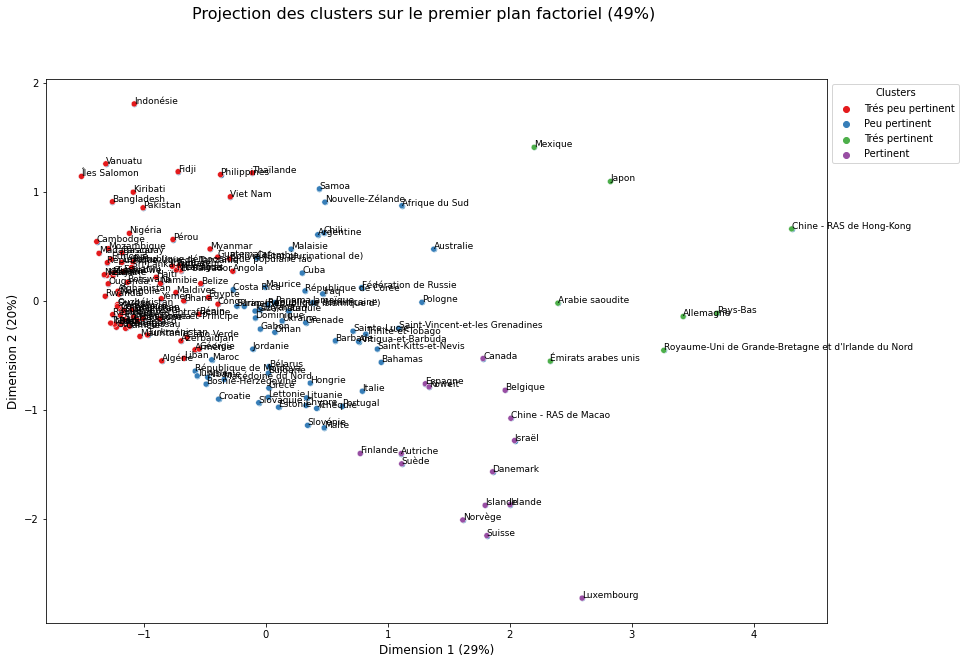

In [51]:
#visualisation du plan factoriel avec labels des pays sur les valeurs en périphérie

fig, ax = plt.subplots(figsize=(14, 10))

scatter = df_pca_filt.plot.scatter("Dim1", "Dim2", ax=ax)

for _, row in df_pca_filt.iterrows():
    ax.annotate(row["Pays"], (row['Dim1'], row['Dim2']), fontsize=9)

plt.xlabel("Dimension 1 (29%)", fontsize=12) 
plt.ylabel("Dimension 2 (20%)", fontsize=12)
plt.suptitle("Projection des clusters sur le premier plan factoriel (49%)", fontsize=16)

sns.scatterplot(data=df_pca_filt, x="Dim1", y="Dim2", hue="Cluster_kmeans", palette="Set1", ax=scatter)
plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')

plt.savefig(
    r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\Projection premier plan.png",
)

plt.show()

Permet de valider la cohérence des clusters effectués par k-means. 
Ici on voit que les clusters sont bien séparés les uns des autres qui suggère une bonne application de kmeans et une séparation des groupes cohérente.

-	En rouge les pays trés peu pertinent, localisés à gauche du nuage
-	En bleu les peu pertinent, plutot centrés
-   En violet les pays pertinents, situé sur le bas a droite du nuage
-	Et en vert les pays identifiés comme très pertinents davantage situés en haut à droite du nuage 

# Comparaison des clusters k-means & CAH 

In [52]:
# Heatmap pour caractériser les differents groupes de clusters des deux méthodes

cross_tab = pd.crosstab(df_no_outliers['Cluster_CAH'], df_no_outliers['Cluster_kmeans'])

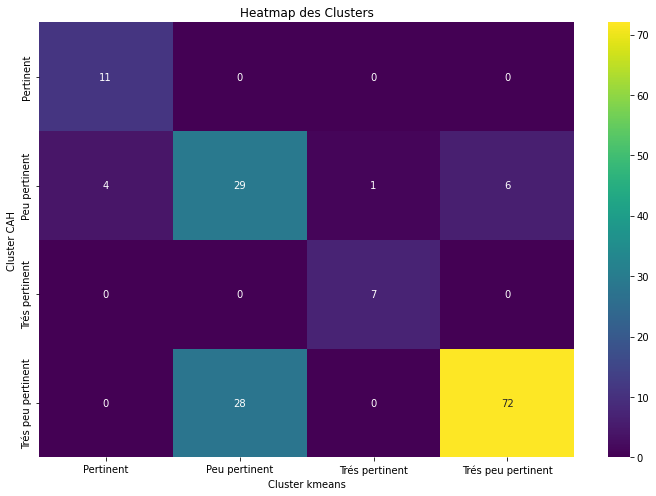

In [53]:
# Création de la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap='viridis')

# Affichage de la heatmap
plt.title("Heatmap des Clusters")
plt.xlabel("Cluster kmeans")
plt.ylabel("Cluster CAH")

plt.savefig(
     r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\heatmap clusters.png",
)

plt.show()

Permet de visualiser les pays appartenant aux mêmes clusters dans les 2 méthodes

Plus la teinte est claire plus le nb d’individus est élévé

72 pays ont étés identifiés comme trés peu pertinents dans les 2 méthodes 

8 pays ont étés identifiés comme Trés pertinent dans la méthodes k means, dont 1 pays qui est dans le cluster "peu pertinent" suite à la méthode CAH

# Isolement des pays dans le cluster "Très pertinent" de la méthode kmeans

In [54]:
best_country = df_no_outliers[(df_no_outliers['Cluster_kmeans'] == "Trés pertinent")]

In [55]:
best_country

,iso3,Pays,Continent,Population,PIB (US$)/hab,Disponibilité alimentaire en quantité (kg/personne/an),Exportations - Quantité(Tonnes),Importations - Quantité(Tonnes),distance,Cluster_kmeans,Cluster_CAH
4,DEU,Allemagne,Europe,82658409.0,44552.819372,19.47,646000.0,842000.0,439.8984,Trés pertinent,Trés pertinent
7,SAU,Arabie saoudite,Asie,33101179.0,20803.745918,43.36,10000.0,722000.0,4694.5000,Trés pertinent,Trés pertinent
30,HKG,Chine - RAS de Hong-Kong,Asie,7306322.0,46165.856512,53.51,663000.0,907000.0,9639.4760,Trés pertinent,Trés pertinent
70,JPN,Japon,Asie,127502725.0,38386.511146,18.50,10000.0,1069000.0,9725.6290,Trés pertinent,Trés pertinent
93,MEX,Mexique,Amérique,124777324.0,9287.849736,32.52,9000.0,972000.0,9206.8130,Trés pertinent,Trés pertinent
110,NLD,Pays-Bas,Europe,17021347.0,48675.222335,20.33,1418000.0,608000.0,427.9169,Trés pertinent,Trés pertinent
115,GBR,Royaume-Uni de Grande-Bretagne et d'Irlande du...,Europe,66727461.0,40361.417383,31.94,359000.0,779000.0,342.9475,Trés pertinent,Trés pertinent
154,ARE,Émirats arabes unis,Asie,9487203.0,40644.804043,43.47,94000.0,433000.0,5249.5350,Trés pertinent,Peu pertinent


### Géomap des 10 meilleurs pays en fonction de leurs importations

In [56]:
best_country_geo = best_country.copy()

In [57]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [58]:
world.rename(columns={'name': 'Pays'}, inplace=True)

In [59]:
best_country["Pays"].unique()

array(['Allemagne', 'Arabie saoudite', 'Chine - RAS de Hong-Kong',
       'Japon', 'Mexique', 'Pays-Bas',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord",
       'Émirats arabes unis'], dtype=object)

In [60]:
country_mapping = {
    'Canada': 'Canada',
    'Japon': 'Japan',
    'Belgique': 'Belgium',
    'Mexique': 'Mexico',
    'Norvège': 'Norway',
    'Arabie saoudite': 'Saudi Arabia',
    'Suède': 'Sweden',
    'Émirats arabes unis': 'United Arab Emirates',
    'Autriche' : 'Austria',
    'Allemagne': 'Germany',
    'Israël': 'Israel',
    'Danemark': 'Denmark',
    'Pays-Bas': 'Netherlands',
    'Irlande': 'Ireland',
    'Espagne': 'Spain',
    'Luxembourg': 'Luxembourg',
    'Islande': 'Iceland',
    'Suisse': 'Switzerland',
    'Suède': 'Sweden',
    'Émirats arabes unis': 'United Arab Emirates',
    'Royaume-Uni de Grande-Bretagne et d\'Irlande du Nord': 'United Kingdom',
    'Chine - RAS de Hong-Kong' : 'China'
}

best_country_geo['Pays'] = best_country_geo['Pays'].map(country_mapping)

In [61]:
merged_geomap = pd.merge(best_country_geo, world, how='outer', on='Pays', indicator=True)

In [62]:
keys_count = merged_geomap['_merge'].value_counts()

print(keys_count)

right_only    169
both            8
left_only       0
Name: _merge, dtype: int64


In [63]:
merged_geomap = gpd.GeoDataFrame(merged_geomap)

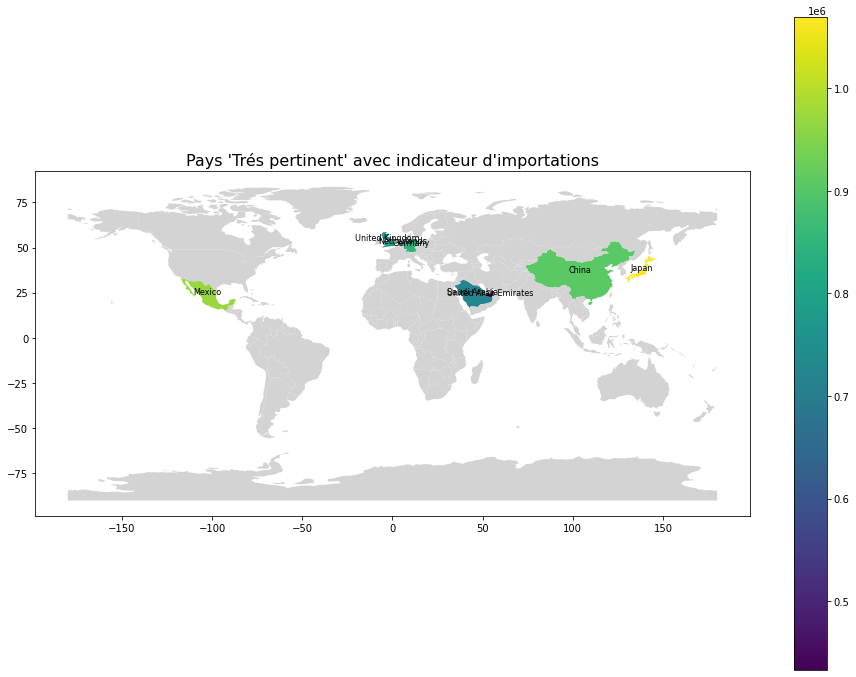

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
merged_geomap.plot(column='Importations - Quantité(Tonnes)', ax=ax, legend=True,
                   missing_kwds={'color': 'lightgrey'})

plt.title("Pays 'Trés pertinent' avec indicateur d'importations", fontsize=16)

for idx, row in merged_geomap.iterrows():
    # Ensure that the geometry is not None and Importations - Quantité(Tonnes) is non-NaN and non-zero
    if row['geometry'] is not None and pd.notnull(row['Importations - Quantité(Tonnes)']) and row['Importations - Quantité(Tonnes)'] != 0:
        ax.annotate(
            text=row['Pays'], 
            xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
            horizontalalignment='center', 
            fontsize=8
        )
plt.savefig(
    r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\geomap import.png",
)

On voit que le Japon est le pays le plus importateurs parmis ces 8 pays, suivi de Mexico et la Chine

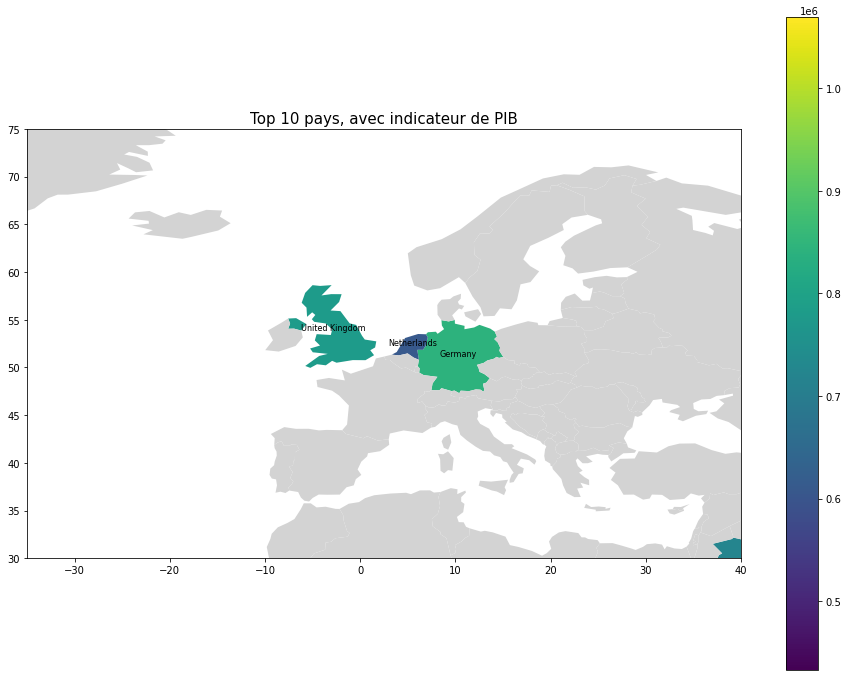

In [65]:
# Zoom sur l'Europe - Géomap des importations

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.set_xlim(-35, 40)
ax.set_ylim(30, 75)
merged_geomap.plot(column="Importations - Quantité(Tonnes)", ax=ax, legend=True,
                   missing_kwds={'color': 'lightgrey'})

plt.title("Top 10 pays, avec indicateur de PIB", fontsize=15)

for idx, row in merged_geomap.iterrows():
    # Ensure that the geometry is not None and Importations - Quantité(Tonnes) is non-NaN and non-zero
    if row['geometry'] is not None and pd.notnull(row['Importations - Quantité(Tonnes)']) and row['Importations - Quantité(Tonnes)'] != 0:
        ax.annotate(
            text=row['Pays'], 
            xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
            horizontalalignment='center', 
            fontsize=8
        )

        plt.savefig(
            r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\geomap import zoom.png",
)

En Europe, c'est l'Allemagne qui importe le plus  

# Scoring pour determiner le top 3 meilleurs pays

## Scénario écologique

In [66]:
weights = { "PIB (US$)/hab" : 5,
"distance" : 8,
"Population" : 6,
"Exportations - Quantité(Tonnes)" : 4,
"Importations - Quantité(Tonnes)" : 4 
}

In [67]:
df_no_outliers['Pays'] = df_no_outliers['Pays'].replace("Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", "Royaume-Uni")

In [68]:
for column in weights.keys():
    if column != 'distance':  # Normal scoring for other variables
        df_no_outliers[column] = (best_country[column] - best_country[column].min()) / (best_country[column].max() - best_country[column].min())
    else:  # Reverse scoring for 'Distance_FRA'
        df_no_outliers[column] = 1 - ((best_country[column] - best_country[column].min()) / (best_country[column].max() - best_country[column].min()))

In [69]:
for column, weight in weights.items():
    df_no_outliers[column] *= weight

In [70]:
df_no_outliers['Score_Total'] = df_no_outliers[list(weights.keys())].sum(axis=1)

# Trier et obtenir les meilleurs pays
latest_top_countries = df_no_outliers.sort_values(by='Score_Total', ascending=False).head(3)

In [71]:
latest_top_countries[['Pays', 'Score_Total']]

,Pays,Score_Total
4,Allemagne,20.674703
115,Royaume-Uni,19.999977
110,Pays-Bas,18.774492


## Scénario business

In [72]:
weights = { "PIB (US$)/hab" : 9,
"distance" : 3,
"Population" : 4,
"Exportations - Quantité(Tonnes)" : 5,
"Importations - Quantité(Tonnes)" : 8 
}

In [73]:
for column in weights.keys():
    if column != 'distance':  # Normal scoring for other variables
        df_no_outliers[column] = (best_country[column] - best_country[column].min()) / (best_country[column].max() - best_country[column].min())
    else:  # Reverse scoring for 'Distance_FRA'
        df_no_outliers[column] = 1 - ((best_country[column] - best_country[column].min()) / (best_country[column].max() - best_country[column].min()))

In [74]:
for column, weight in weights.items():
    df_no_outliers[column] *= weight

In [75]:
df_no_outliers['Score_Total'] = df_no_outliers[list(weights.keys())].sum(axis=1)

# Trier et obtenir les meilleurs pays
latest_top_countries = df_no_outliers.sort_values(by='Score_Total', ascending=False).head(3)

In [76]:
latest_top_countries[['Pays', 'Score_Total']]

,Pays,Score_Total
30,Chine - RAS de Hong-Kong,21.737216
4,Allemagne,21.078320
110,Pays-Bas,19.758749
